In [5]:
import pandas as pd

# Load dataset
file_path = 'antenna_dataset_complete.csv'
antenna_data = pd.read_csv(file_path)

# Display dataset structure
print(antenna_data.info())
print(antenna_data.head())


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1000 entries, 0 to 999
Data columns (total 13 columns):
 #   Column                 Non-Null Count  Dtype  
---  ------                 --------------  -----  
 0   Patch_Length_mm        1000 non-null   float64
 1   Patch_Width_mm         1000 non-null   float64
 2   Slot_Length_mm         1000 non-null   float64
 3   Slot_Width_mm          1000 non-null   float64
 4   Substrate_Height_mm    1000 non-null   float64
 5   Relative_Permittivity  1000 non-null   float64
 6   Frequency_GHz          1000 non-null   float64
 7   Gain_dB                1000 non-null   float64
 8   Directivity            1000 non-null   float64
 9   S11_dB                 1000 non-null   float64
 10  Bandwidth_MHz          1000 non-null   float64
 11  Radiation_Efficiency   1000 non-null   float64
 12  Impedance_Match        1000 non-null   float64
dtypes: float64(13)
memory usage: 101.7 KB
None
   Patch_Length_mm  Patch_Width_mm  Slot_Length_mm  Slot_Width_mm 

In [6]:
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler

# Define features and target variables
input_features = [
    'Patch_Length_mm', 'Patch_Width_mm', 'Slot_Length_mm', 'Slot_Width_mm',
    'Substrate_Height_mm', 'Relative_Permittivity', 'Frequency_GHz'
]
targets = ['Gain_dB', 'Directivity', 'S11_dB', 'Bandwidth_MHz', 'Radiation_Efficiency']

# Split the data
X = antenna_data[input_features].values  # Convert to NumPy array
y = antenna_data[targets].values         # Convert to NumPy array
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Normalize the data
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)


In [7]:
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_squared_error

# Train the model
model = RandomForestRegressor(n_estimators=100, random_state=42)
model.fit(X_train_scaled, y_train)

# Evaluate the model
y_pred = model.predict(X_test_scaled)
mse = mean_squared_error(y_test, y_pred, multioutput='raw_values')
print(f"Mean Squared Errors for Targets: {dict(zip(targets, mse))}")

Mean Squared Errors for Targets: {'Gain_dB': 0.2580727312041875, 'Directivity': 0.18065892884479515, 'S11_dB': 1.5152320967914596, 'Bandwidth_MHz': 23.40562753108877, 'Radiation_Efficiency': 12.512365916723542}


In [8]:
import numpy as np
from scipy.optimize import differential_evolution

# Define the objective function
def objective_function(parameters):
    parameters = np.array(parameters).reshape(1, -1)
    scaled_params = scaler.transform(parameters)
    predictions = model.predict(scaled_params)
    # Objective: Maximize Gain and minimize S11
    gain, _, s11, _, _ = predictions[0]
    return -gain + abs(s11)

# Define bounds for the parameters
bounds = [
    (antenna_data['Patch_Length_mm'].min(), antenna_data['Patch_Length_mm'].max()),
    (antenna_data['Patch_Width_mm'].min(), antenna_data['Patch_Width_mm'].max()),
    (antenna_data['Slot_Length_mm'].min(), antenna_data['Slot_Length_mm'].max()),
    (antenna_data['Slot_Width_mm'].min(), antenna_data['Slot_Width_mm'].max()),
    (antenna_data['Substrate_Height_mm'].min(), antenna_data['Substrate_Height_mm'].max()),
    (antenna_data['Relative_Permittivity'].min(), antenna_data['Relative_Permittivity'].max()),
    (antenna_data['Frequency_GHz'].min(), antenna_data['Frequency_GHz'].max()),
]

# Run the optimization
result = differential_evolution(objective_function, bounds, strategy='best1bin', maxiter=100, seed=42)
optimized_parameters = result.x
print("Optimized Design Parameters:", optimized_parameters)


Optimized Design Parameters: [30.28198811 48.4791916   6.95541455  5.8112788   3.2613678   3.0370824
  2.78107441]


Optimized Performance Metrics: {'Gain_dB': 10.11239074612041, 'Directivity': 6.93055603808747, 'S11_dB': -8.496795439221813, 'Bandwidth_MHz': 77.50880928519983, 'Radiation_Efficiency': 65.0056742891404}


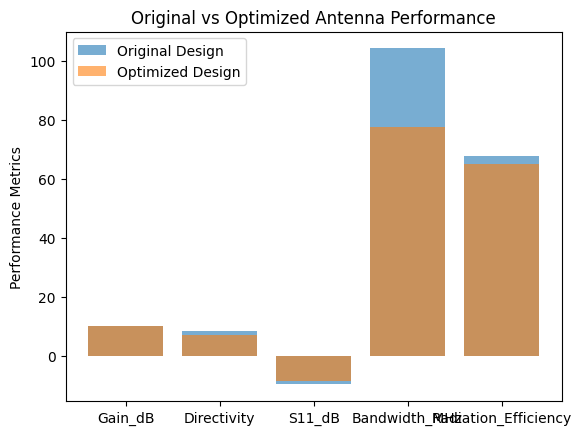

In [9]:
# Predict performance of optimized design
optimized_params_scaled = scaler.transform([optimized_parameters])
optimized_performance = model.predict(optimized_params_scaled)
print("Optimized Performance Metrics:", dict(zip(targets, optimized_performance[0])))

# Visualize comparison with an example original design
import matplotlib.pyplot as plt

original_performance = y_test[0]  # Example comparison with first test data
plt.bar(targets, original_performance, alpha=0.6, label='Original Design')
plt.bar(targets, optimized_performance[0], alpha=0.6, label='Optimized Design')
plt.ylabel("Performance Metrics")
plt.title("Original vs Optimized Antenna Performance")
plt.legend()
plt.show()


In [10]:
import joblib

# Save the trained model and scaler
joblib.dump(model, 'antenna_model.pkl')
joblib.dump(scaler, 'scaler.pkl')

print("Model and scaler have been saved successfully.")


Model and scaler have been saved successfully.


In [11]:
# Load the saved model and scaler
loaded_model = joblib.load('antenna_model.pkl')
loaded_scaler = joblib.load('scaler.pkl')

# Define a prediction function
def predict_antenna_performance(design_parameters):
    """
    Predict the performance of a patch antenna given its design parameters.

    Parameters:
    - design_parameters: List or array of design parameters
      [Patch_Length_mm, Patch_Width_mm, Slot_Length_mm, Slot_Width_mm,
       Substrate_Height_mm, Relative_Permittivity, Frequency_GHz]

    Returns:
    - Dictionary of predicted performance metrics
    """
    # Convert parameters to a NumPy array
    design_parameters = np.array(design_parameters).reshape(1, -1)

    # Scale the parameters
    scaled_parameters = loaded_scaler.transform(design_parameters)

    # Predict performance
    performance_metrics = loaded_model.predict(scaled_parameters)[0]

    # Map predictions to their corresponding targets
    performance_dict = dict(zip(targets, performance_metrics))

    return performance_dict


In [12]:
# Example design parameters (replace with real values)
example_design = [
    15.0,  # Patch_Length_mm
    10.0,  # Patch_Width_mm
    5.0,   # Slot_Length_mm
    2.0,   # Slot_Width_mm
    1.5,   # Substrate_Height_mm
    4.4,   # Relative_Permittivity
    2.45   # Frequency_GHz
]

# Predict performance
predicted_performance = predict_antenna_performance(example_design)
print("Predicted Performance Metrics:", predicted_performance)


Predicted Performance Metrics: {'Gain_dB': 10.045159543994714, 'Directivity': 7.020336677306375, 'S11_dB': -10.545577881345498, 'Bandwidth_MHz': 82.21314597960894, 'Radiation_Efficiency': 67.52333433761002}
